# MURA X-ray dataset을 이용해서 분류 문제를 풀어보자.

먼저 data를 colab에 load하고 preprocessing, 관찰하자.


## 필요한 library 부터 불러오자

In [2]:
#Zip file unzip에 필요한 
import os 
import zipfile

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
%matplotlib inline

#import warning
#warning.filterwarnings('ignore')

from glob import glob

import keras 
import keras.backend as k

Using TensorFlow backend.


## Dataset 불러오기 및 확인 관찰

Stanford ML lab의 X-ray dataset인 MURA dataset은 다음의 링크에서 다운로드한다. 

https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip

In [3]:
!wget \
  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip \
  -O /tmp/MURA.zip

--2019-06-04 04:45:48--  https://cs.stanford.edu/group/mlgroup/MURA-v1.1.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3380245855 (3.1G) [application/zip]
Saving to: ‘/tmp/MURA.zip’

/tmp/MURA.zip       100%[===================>]   3.15G  6.29MB/s    in 13m 30s 

2019-06-04 04:59:19 (3.98 MB/s) - ‘/tmp/MURA.zip’ saved [3380245855/3380245855]



"MURA.zip" 파일이 colab의 tmp 폴더에 다운로드 되었다. 

이 파일을 extract 할텐데, 이 때는 os library와 zipfile library를 사용한다.

In [0]:
# zip file의 위치를 변수에 지정해주고...
local_zip = "/tmp/MURA.zip"

# 변수의 파일을 unzip하도록한다.
zip_ref = zipfile.ZipFile(local_zip, 'r')

# unzip 할 폴더를 지정하고
zip_ref.extractall('/tmp')

# 작업 종료
zip_ref.close()

In [5]:
os.listdir('/tmp')

['MURA.zip', 'MURA-v1.1']

In [0]:
PATH = '/tmp/MURA-v1.1/'

In [7]:
os.listdir(PATH)

['valid_image_paths.csv',
 'train_labeled_studies.csv',
 'train_image_paths.csv',
 'train',
 'valid_labeled_studies.csv',
 'valid']

In [0]:
train_image_path = pd.read_csv(PATH+'train_image_paths.csv', names=['img path'])
train_labels = pd.read_csv(PATH+'train_labeled_studies.csv', names=['img path', 'Labels'])

valid_image_path = pd.read_csv(PATH+'valid_image_paths.csv', names=['img path'])
valid_labels = pd.read_csv(PATH+'valid_labeled_studies.csv', names=['img path', 'Labels'])

### Train data에 대해서 더 살펴보자

In [9]:
print(train_image_path.head())
print(train_image_path.shape)
print(train_image_path.info())

                                            img path
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...
1  MURA-v1.1/train/XR_SHOULDER/patient00001/study...
2  MURA-v1.1/train/XR_SHOULDER/patient00001/study...
3  MURA-v1.1/train/XR_SHOULDER/patient00002/study...
4  MURA-v1.1/train/XR_SHOULDER/patient00002/study...
(36808, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36808 entries, 0 to 36807
Data columns (total 1 columns):
img path    36808 non-null object
dtypes: object(1)
memory usage: 287.6+ KB
None


**36807**개의 data가 있다. 

각각 row의 값은 image의 경로를 의미한다.

labeling은 어떻게 되어 있을까?

In [10]:
print(train_labels.columns)
print(train_labels.head(10))

Index(['img path', 'Labels'], dtype='object')
                                            img path  Labels
0  MURA-v1.1/train/XR_SHOULDER/patient00001/study...       1
1  MURA-v1.1/train/XR_SHOULDER/patient00002/study...       1
2  MURA-v1.1/train/XR_SHOULDER/patient00003/study...       1
3  MURA-v1.1/train/XR_SHOULDER/patient00004/study...       1
4  MURA-v1.1/train/XR_SHOULDER/patient00005/study...       1
5  MURA-v1.1/train/XR_SHOULDER/patient00006/study...       1
6  MURA-v1.1/train/XR_SHOULDER/patient00007/study...       1
7  MURA-v1.1/train/XR_SHOULDER/patient00007/study...       0
8  MURA-v1.1/train/XR_SHOULDER/patient00008/study...       1
9  MURA-v1.1/train/XR_SHOULDER/patient00009/study...       1


**0**과 **1**로 labeling이 되어있는듯 하다.

In [11]:
train_labels.shape

(13457, 2)

In [12]:
train_labels['Labels'].value_counts()

0    8280
1    5177
Name: Labels, dtype: int64

### 이번엔 Validation data에 대해서살펴보자

In [13]:
valid_image_path.head()

,img path
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...


In [14]:
valid_image_path.shape

(3197, 1)

In [15]:
valid_image_path.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3197 entries, 0 to 3196
Data columns (total 1 columns):
img path    3197 non-null object
dtypes: object(1)
memory usage: 25.1+ KB


### 이미지 확인

각각의 폴더에 있는 이미지들을 한번 확인해보자

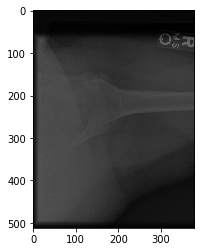

(512, 380, 3)


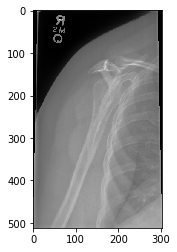

(512, 303, 3)


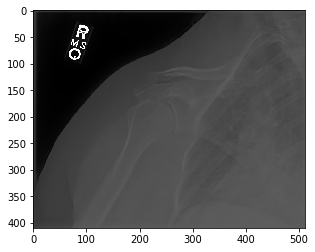

(410, 512, 3)


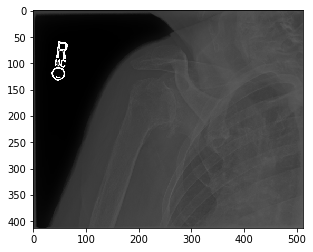

(413, 512, 3)


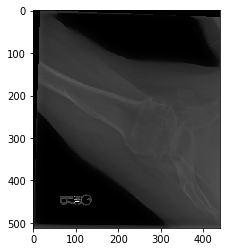

(512, 440, 3)


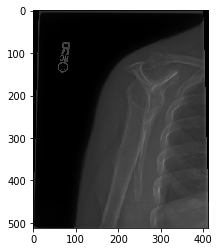

(512, 413, 3)


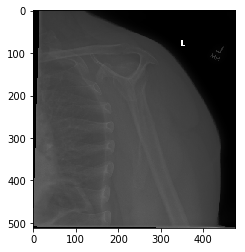

(512, 476, 3)


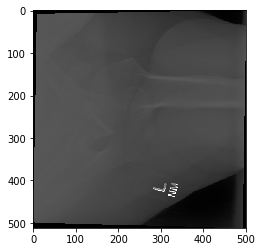

(512, 501, 3)


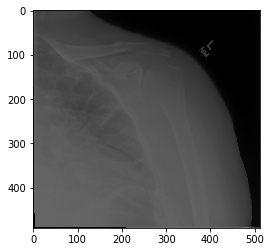

(491, 512, 3)


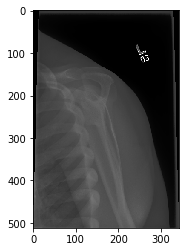

(512, 343, 3)


In [16]:
for path in train_image_path.values[:10]:
  img = cv2.imread('/tmp/'+path[0])
  plt.imread('/tmp/'+path[0])
  plt.imshow(img)
  plt.show()
  print(img.shape)
  

### Dataset에 문제가 좀...

 label csv file은 data의 경로와 각각의 labe을 쭉 나열한 것...
 
 각 부위별 숫자 통계나 이런건...image파일들을 일일이 들여나 보나?
 
 음...train_image_path의 파일을 한번 살펴보자.

In [17]:
train_labels.values[0:10]

array([['MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/', 1],
       ['MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/', 1],
       ['MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/', 1],
       ['MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/', 1],
       ['MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/', 1],
       ['MURA-v1.1/train/XR_SHOULDER/patient00006/study1_positive/', 1],
       ['MURA-v1.1/train/XR_SHOULDER/patient00007/study1_positive/', 1],
       ['MURA-v1.1/train/XR_SHOULDER/patient00007/study2_negative/', 0],
       ['MURA-v1.1/train/XR_SHOULDER/patient00008/study1_positive/', 1],
       ['MURA-v1.1/train/XR_SHOULDER/patient00009/study1_positive/', 1]],
      dtype=object)

신체부위와 study type 정도는 따로 분류해 내면 통계를 내는 데에 유의할 듯...


In [0]:
train_labels['body_part'] = train_labels['img path'].apply(lambda x: str(x.split('/')[2])[3:])
train_labels['study_type']=train_labels['img path'].apply(lambda x: str(x.split('/')[4])[:6])
valid_labels['body_part']=valid_labels['img path'].apply(lambda x: str(x.split('/')[2])[3:])
valid_labels['study_type']=valid_labels['img path'].apply(lambda x: str(x.split('/')[4])[:6])

In [19]:
train_labels.head()

,img path,Labels,body_part,study_type
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,SHOULDER,study1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,SHOULDER,study1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1,SHOULDER,study1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1,SHOULDER,study1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1,SHOULDER,study1


In [20]:
valid_labels.head()

,img path,Labels,body_part,study_type
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,1,WRIST,study1
1,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,1,WRIST,study1
2,MURA-v1.1/valid/XR_WRIST/patient11186/study2_p...,1,WRIST,study2
3,MURA-v1.1/valid/XR_WRIST/patient11186/study3_p...,1,WRIST,study3
4,MURA-v1.1/valid/XR_WRIST/patient11187/study1_p...,1,WRIST,study1


## Data Visualization

### 먼저 'abnormal : 1' 과 'normal: 0'

0    8280
1    5177
Name: Labels, dtype: int64


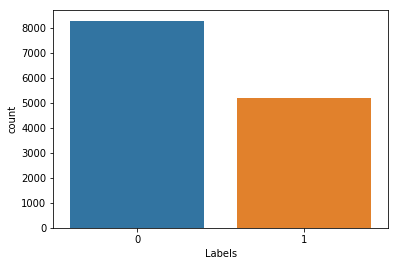

In [21]:
sns.countplot(train_labels['Labels'])

print(train_labels['Labels'].value_counts())

### 부위별 정상과 비정상 한번 볼까?

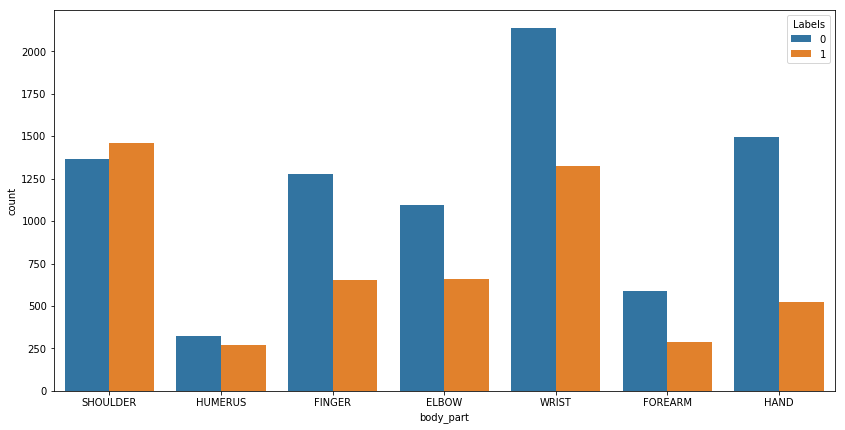

In [22]:
plt.figure(figsize=(14,7))
sns.countplot(data=train_labels, x='body_part', hue='Labels')

### study type 별로도 한번 보자.

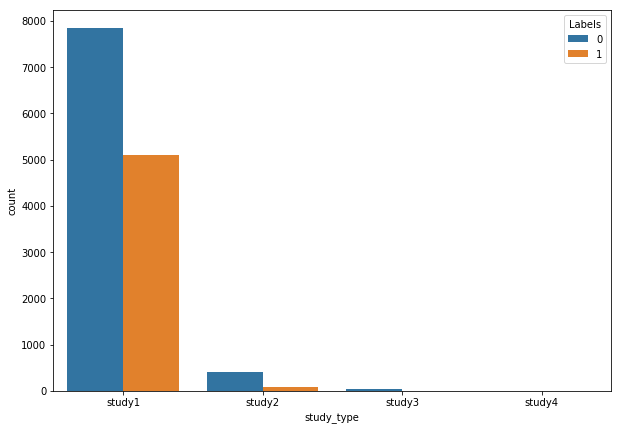

In [23]:
plt.figure(figsize=(10,7))
sns.countplot(data=train_labels, x='study_type', hue='Labels')

### Validation data에서도 똑같이

0    661
1    538
Name: Labels, dtype: int64


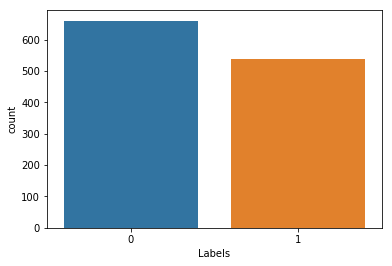

In [24]:
sns.countplot(valid_labels['Labels'])
print(valid_labels['Labels'].value_counts())

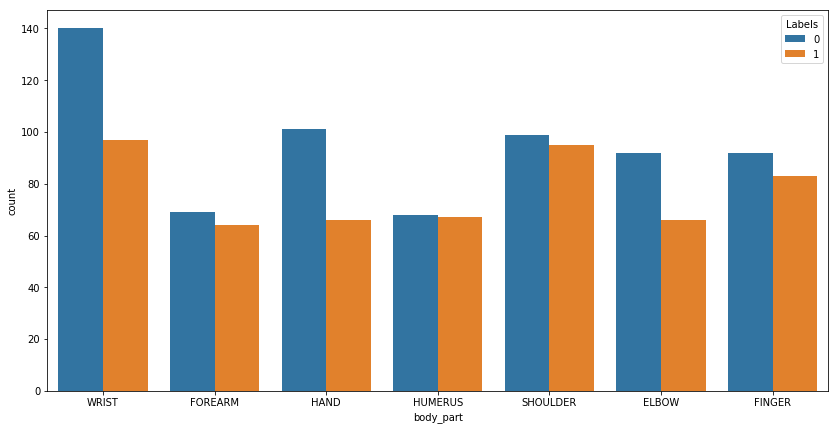

In [25]:
plt.figure(figsize=(14,7))
sns.countplot(data=valid_labels, x='body_part', hue='Labels')

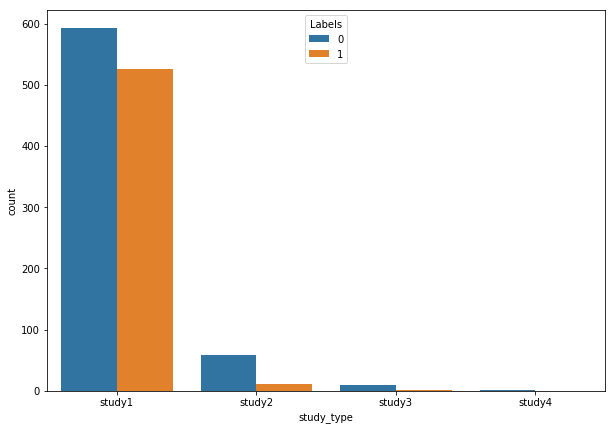

In [26]:
plt.figure(figsize=(10,7))
sns.countplot(data=valid_labels, x='study_type', hue='Labels')

## Data 전처리

Data는 잘 살펴보았으니...이제 학습을 위해서는 뭘 해야할까?

가장 중요한 과정 바로 이미지 전처리 **image preprocessing**과정이 필요하다. 

전처리를 위해서 어떤 것들을 고려할지 한번 생각해보자.

가장 중요한 선결 조건은 바로 image shape을 일정하게 맞추는 것이다. 

앞서 이미지들을 보았듯이 image는 color data로 저장되어있고, image size 역시 제각각이다. 

이 이미지 파일들은 x-ray 파일이기 때문에 color data는 gray data로 바꿔도 지장이 없을 것이다. 오히려 evaluation을 위해서는 단순화 하는 것이 더 나을 듯. 

shape은 (224, 224, 1)로 맞추는 걸로...

왜? 

VGG original 이 224x224였다.

In [0]:
def image_read(image_path):
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (224,224))
  img = np.array(img)
  img = img/255.0
  return img

In [0]:
train_labels['img path']=train_image_path['img path']
valid_labels['img path']=valid_image_path['img path']

In [0]:
train_df=train_labels.groupby(['Labels']).apply(lambda x: x.sample(5000,replace=True))

In [30]:
train_df.shape

(10000, 4)

In [31]:

train_labels.shape

(13457, 4)

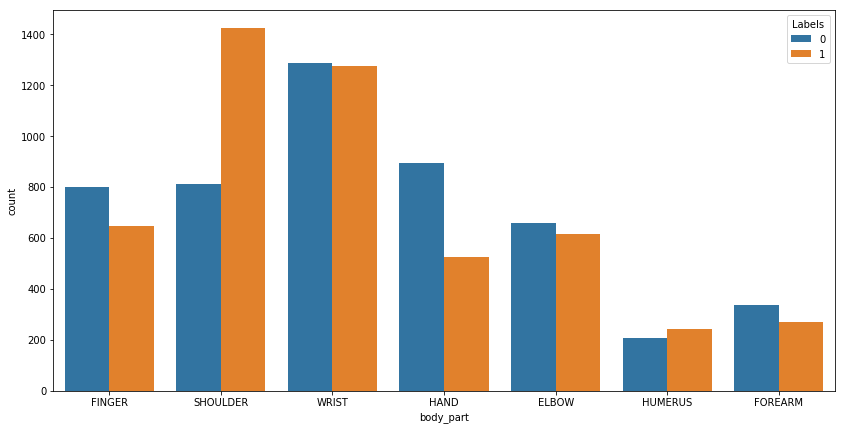

In [32]:
plt.figure(figsize=(14,7))
sns.countplot(data=train_df, x='body_part', hue='Labels')

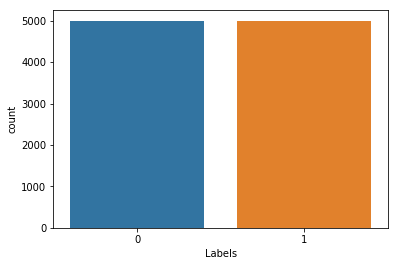

In [33]:
sns.countplot(train_df['Labels'])

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [0]:
img_size = (224, 224)

datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=30,
                             fill_mode='nearest',
                             preprocessing_function=preprocess_input)

In [0]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname('/tmp/'+in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = '/tmp/'+in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [37]:
train_gen = flow_from_dataframe(datagen, train_df, 
                                path_col = 'img path',
                                y_col = 'Labels', 
                                target_size = img_size,
                                color_mode = 'rgb',
                                batch_size = 64)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 10000 images


In [38]:
valid_gen = flow_from_dataframe(datagen, valid_labels, 
                                path_col = 'img path',
                                y_col = 'Labels', 
                                target_size = img_size,
                                color_mode = 'rgb',
                                batch_size = 64)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1199 images


In [39]:
valid_X, valid_Y = next(flow_from_dataframe(datagen, valid_labels, 
                                            path_col = 'img path',
                                            y_col = 'Labels', 
                                            target_size = img_size,
                                            color_mode = 'rgb',
                                            batch_size = 64)) # one big batch
# used a fixed dataset for final evaluation
final_test_X, final_test_Y = next(flow_from_dataframe(datagen, valid_labels, 
                                                      path_col = 'img path',
                                                      y_col = 'Labels',
                                                      target_size = img_size,
                                                      color_mode = 'rgb',
                                                      batch_size = 64)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1199 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1199 images


In [0]:
train_X, train_Y = next(train_gen)

In [41]:
print(train_X.shape)
print(train_Y.shape)

(64, 224, 224, 3)
(64,)


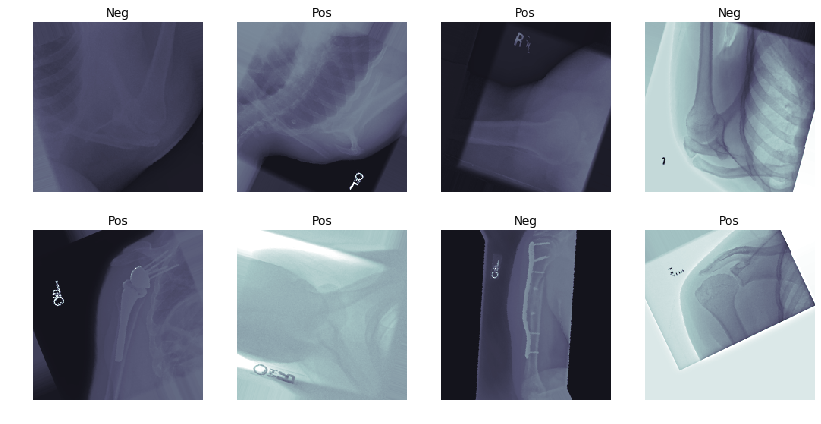

In [42]:
fig, m_axs = plt.subplots(2,4, figsize=(14,7))

for (x, y, ax) in zip(train_X, train_Y, m_axs.flatten()):
  ax.imshow(x[:,:,0], cmap='bone', vmin=-127, vmax=127)
  ax.set_title('%s' % ('Pos' if y>0.5 else 'Neg'))
  ax.axis('off')

## VGG16 model로 training을 해보자

In [0]:
import tensorflow as tf 
import tensorflow.keras.layers

In [44]:
vgg_model = VGG16(input_shape=train_X.shape[1:], include_top=False, weights='imagenet')
vgg_model.trainable=False

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 8s 0us/step


In [45]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential

### 일단 간단하게 VGG model 뒤에 Dense layer만 붙여서 해보자.

In [47]:
add_model = Sequential([
    vgg_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [48]:
add_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________


### Callback function

In [49]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cardio_attn')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

모델을 학습시키기 위해서는 

1. 모델을 통한 예측값과 실제값의 차이를 계산 : **loss function**을 정하고,

2. 그 loss 값을 gradient descent를 통해서 0으로 수렴시키기 위한 **optimization function**을 정한다. 

우선 loss function은 multi-label prediction일 경우에는 categorical crossentropy 함수를 사용하지만, 이 모델은 binary classification 문제이므로 **binary crossentropy**를 사용할 예정.

optimizer는 Adam을 선호해서 사용하지만, 여기에서는 먼저 strochastic gradient descent를 위한 **RMSprop** optimization algorithm을 먼저 시도해본다. 

In [0]:
from tensorflow.keras.optimizers import RMSprop

add_model.compile(optimizer=RMSprop(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [53]:
history = add_model.fit_generator(train_gen,
                              validation_data=valid_gen, 
                              steps_per_epoch=100, 
                              epochs=30, 
                              validation_steps=50, 
                              callbacks = callbacks_list,
                              verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
19/19 [==============================] - 24s 1s/step - loss: 0.7905 - acc: 0.5338

Epoch 00001: val_loss improved from inf to 0.79051, saving model to cardio_attn_weights.best.hdf5
 - 156s - loss: 1.0033 - acc: 0.5678 - val_loss: 0.7905 - val_acc: 0.5338
Epoch 2/30
19/19 [==============================] - 20s 1s/step - loss: 0.8164 - acc: 0.5546

Epoch 00002: val_loss did not improve from 0.79051
 - 141s - loss: 0.6999 - acc: 0.6105 - val_loss: 0.8164 - val_acc: 0.5546
Epoch 3/30
19/19 [==============================] - 20s 1s/step - loss: 0.8387 - acc: 0.5338

Epoch 00003: val_loss did not improve from 0.79051
 - 142s - loss: 0.6907 - acc: 0.6185 - val_loss: 0.8387 - val_acc: 0.5338
Epoch 4/30
19/19 [==============================] - 20s 1s/step - loss: 0.9785 - acc: 0.5379

Epoch 00004: val_loss did not improve from 0.79051
 - 140s - loss: 0.6749 - acc: 0.6311 - val_loss: 0.9785 - val_acc: 0.5379
Epoch 5/30
19/19 [===========

### Evaluating Accuracy and Loss for the Model

Text(0.5, 1.0, 'Training and validation loss')

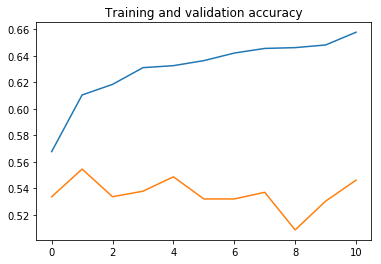

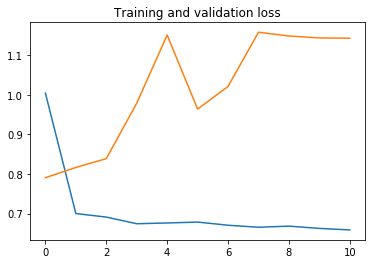

In [54]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'acc' ]
val_acc  = history.history[ 'val_acc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [55]:
import random
import tensorflow as tf
from   tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in vgg_model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = vgg_model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.

for path in random.choice(train_image_path.values):
  img_path = '/tmp/'+path
  img = load_img(img_path, target_size=(224, 224))
 
print(img_path)
  
x   = img_to_array(img)                           # Numpy array with shape (224, 224, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 224, 224, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in add_model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 200. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

Output hidden; open in https://colab.research.google.com to view.

## Clean up

In [0]:
import os, signal

os.kill(     os.getpid() ,
         signal.SIGKILL
       )

In [0]:
vgg_model.input

<tf.Tensor 'input_1:0' shape=(?, 224, 224, 3) dtype=float32>

In [0]:
train_image_path.values